## Imports

In [29]:
import os
import re
import spacy
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

## Data loading

In [7]:
filename = "boardgames.csv"
df = pd.read_csv(filename, sep=";")
df.head()

,id,name,description,year,rating,complexity
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58934,4.3081
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.65971,1.9643
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47612,2.4423
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35072,2.4923


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

In [10]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

# We implement data cleaning using spaCy
def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize words, and exclude punctuations
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    return " ".join(tokens)

In [11]:
# Apply the cleaning function to all descriptions
df["clean_description"] = df["description"].apply(clean_text)

In [12]:
# Example: original and cleaned text for first entry
print("Original:\n", df["description"][0])
print("Cleaned:\n", df["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

#### Save clean dataset (if desired)

In [13]:
df.to_csv("boardgames_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

In [14]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in df["clean_description"]]

In [15]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [18]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

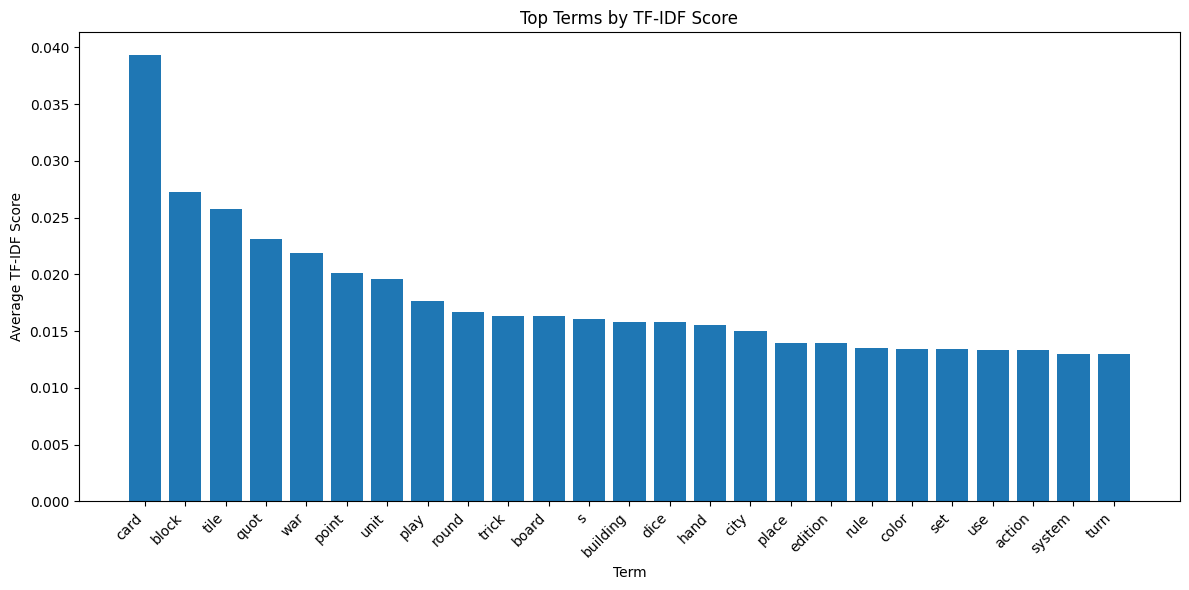

In [23]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

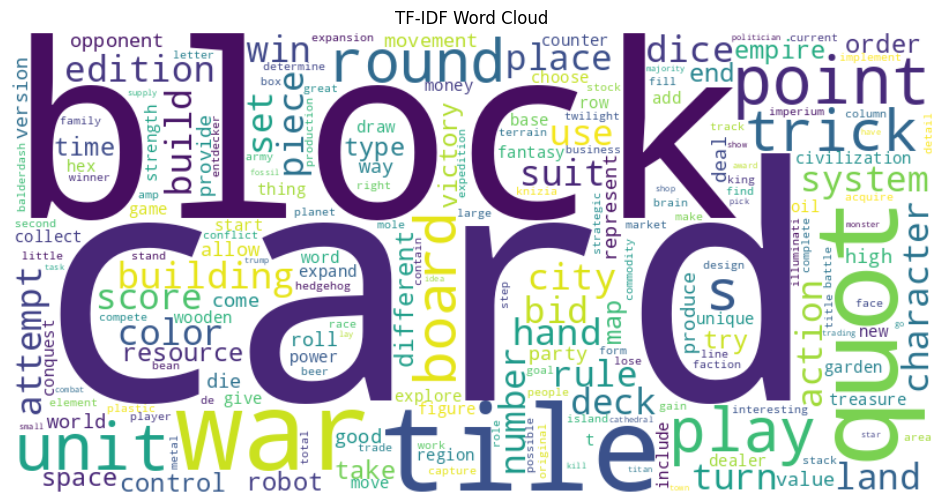

In [22]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

#### GloVe and Doc2Vec

In [28]:
# Load pretrained GloVe
w2v_model = gensim.downloader.load("glove-wiki-gigaword-100")

def get_avg_vector(doc):
    words = doc.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack(df["clean_description"].apply(get_avg_vector))

[==================================================] 100.0% 128.1/128.1MB downloaded


In [30]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

#### LDA

In [31]:
corpus = df['clean_description'].tolist()

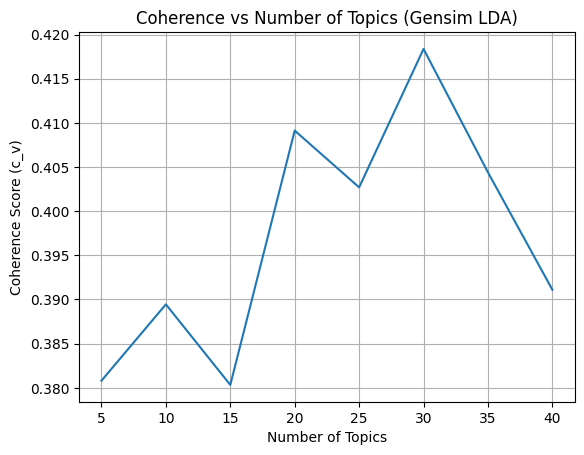

In [37]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 41, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
import matplotlib.pyplot as plt
plt.plot(range(5, 41, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]